# Proyecto Capstone - La Batalla de los Vecindarios

## Descripción del problema y discusión de antecedentes
El objetivo de este proyecto es encontrar el mejor lugar en Toronto (Canadá) para abrir un restaurante de pastas utilizando datos de Foursquare. En general, se analizarán criterios que ayudarán a tener una alta tasa de éxito.

## Descripción de los datos y cómo se utilizarán para resolver el problema

Fuente 1: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M Contiene información sobre los códigos postales de ciudades de Canadá.

Fuente 2: https://cocl.us/Geospatial_data Contiene coordenadas geográficas de los vecindarios y sus códigos postales.

Fuente 3: https://foursquare.com/developers/apps Se puede obtener el nombre, categoría, lat y long.

En general, lo que se busca es resolver el problema a través de la data, tomar coordenadas de los vecindarios usando el paquete geocoder y realizar clustering de los vecindarios.

In [1]:
!pip install geopy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install beautifulsoup4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install kmeans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for kmeans: filename=kmeans-1.0.2-cp37-cp37m-linux_x86_64.whl size=11798 sha256=fb7c2e7763879427a9b28fd701cda8df0b3f6d7985a0f928407e45b4ca0e1718
  Stored in directory: /root/.cache/pip/wheels/4a/26/51/688c6987fdc6a10c6186c3817f2ef7c92c50c078a900525c0e
Successfully built kmeans


In [5]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import numpy as np 
import pandas as pd 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

import requests 
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt 

from sklearn.cluster import KMeans

import folium 

In [8]:
#Obteniendo la data de los vecindarios usand beautiful soup
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

soup = BeautifulSoup(str(data_html))

In [9]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3] 
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df=pd.DataFrame(table_contents)

df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [10]:
#Preparación para el procesamiento de data
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)

In [11]:
df_dropna.isnull().sum()

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

In [12]:
df_dropna.loc[df_dropna['Borough'].isin(["Not assigned"])]

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

In [13]:
df = df_dropna
df.head()

PostalCode           Borough                      Neighborhood
0        M3A        North York                         Parkwoods
1        M4A        North York                  Victoria Village
2        M5A  Downtown Toronto         Regent Park, Harbourfront
3        M6A        North York  Lawrence Manor, Lawrence Heights
4        M7A      Queen's Park     Ontario Provincial Government

In [14]:
df.shape

(103, 3)

In [15]:
#agregamos la latitud y longitud a cada código postal
geo_url = "https://cocl.us/Geospatial_data"
geo_df = pd.read_csv(geo_url)
geo_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
geo_df.head()

PostalCode   Latitude  Longitude
0        M1B  43.806686 -79.194353
1        M1C  43.784535 -79.160497
2        M1E  43.763573 -79.188711
3        M1G  43.770992 -79.216917
4        M1H  43.773136 -79.239476

In [16]:
#combinamos la data
df = pd.merge(df, geo_df, on='PostalCode')
df.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [17]:
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto            9
Downtown Toronto          17
Downtown Toronto Stn A     1
East Toronto               4
East Toronto Business      1
East York                  4
East York/East Toronto     1
Etobicoke                 11
Etobicoke Northwest        1
Mississauga                1
North York                24
Queen's Park               1
Scarborough               17
West Toronto               6
York                       5
Name: Neighborhood, dtype: int64

In [18]:
df_toronto = df
df_toronto.head()

PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494

In [19]:
boroughs = df_toronto['Borough'].unique().tolist()

In [20]:

lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()
print('Las coordenadas geográficas de Toronto son {}, {}'.format(lat_toronto, lon_toronto))

Las coordenadas geográficas de Toronto son 43.704607733980595, -79.39715291165048


In [21]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

In [22]:
CLIENT_ID = 'LVNSPMLTBBDPN2INEYVDDVFWLONMFATTHN1UXOKODIXDTMZA'
CLIENT_SECRET = 'UU3FWAT2QOHGJHGYAGR54F5GFB4NJZFNDITCJZUTFCNW2OYI'
VERSION = 20200514 # Foursquare API version

print('Credentials Stored')

Credentials Stored


In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100 
    radius = 500 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [27]:
toronto_venues.tail()

Neighborhood  \
2140  Mimico NW, The Queensway West, South of Bloor,...   
2141  Mimico NW, The Queensway West, South of Bloor,...   
2142  Mimico NW, The Queensway West, South of Bloor,...   
2143  Mimico NW, The Queensway West, South of Bloor,...   
2144  Mimico NW, The Queensway West, South of Bloor,...   

      Neighborhood Latitude  Neighborhood Longitude  \
2140              43.628841              -79.520999   
2141              43.628841              -79.520999   
2142              43.628841              -79.520999   
2143              43.628841              -79.520999   
2144              43.628841              -79.520999   

                            Venue  Venue Latitude  Venue Longitude  \
2140  Islington Florist & Nursery       43.630156       -79.518718   
2141            Once Upon A Child       43.631075       -79.518290   
2142                Value Village       43.631269       -79.518238   
2143         Kingsway Boxing Club       43.627254       -79.526684   
2144                 Burrito Boyz       43.626657       -79.526349   

              Venue Category  
2140             Flower Shop  
2141              Kids Store  
2142  Thrift / Vintage Store  
2143                     Gym  
2144           Burrito Place

In [28]:
toronto_venues.groupby('Neighborhood').count().head()

Neighborhood Latitude  \
Neighborhood                                                             
Agincourt                                                            5   
Alderwood, Long Branch                                               8   
Bathurst Manor, Wilson Heights, Downsview North                     20   
Bayview Village                                                      4   
Bedford Park, Lawrence Manor East                                   20   

                                                 Neighborhood Longitude  \
Neighborhood                                                              
Agincourt                                                             5   
Alderwood, Long Branch                                                8   
Bathurst Manor, Wilson Heights, Downsview North                      20   
Bayview Village                                                       4   
Bedford Park, Lawrence Manor East                                    20   

                                                 Venue  Venue Latitude  \
Neighborhood                                                             
Agincourt                                            5               5   
Alderwood, Long Branch                               8               8   
Bathurst Manor, Wilson Heights, Downsview North     20              20   
Bayview Village                                      4               4   
Bedford Park, Lawrence Manor East                   20              20   

                                                 Venue Longitude  \
Neighborhood                                                       
Agincourt                                                      5   
Alderwood, Long Branch                                         8   
Bathurst Manor, Wilson Heights, Downsview North               20   
Bayview Village                                                4   
Bedford Park, Lawrence Manor East                             20   

                                                 Venue Category  
Neighborhood                                                     
Agincourt                                                     5  
Alderwood, Long Branch                                        8  
Bathurst Manor, Wilson Heights, Downsview North              20  
Bayview Village                                               4  
Bedford Park, Lawrence Manor East                            20

In [29]:
print('There are {} uniques vanue categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 272 uniques vanue categories.


In [30]:
print("The Venue Categories are", toronto_venues['Venue Category'].unique()[:20])

The Venue Categories are ['Park' 'Fast Food Restaurant' 'Food & Drink Shop' 'Hockey Arena'
 'Coffee Shop' 'Portuguese Restaurant' 'Intersection' 'Pizza Place'
 'Bakery' 'Distribution Center' 'New American Restaurant' 'Spa'
 'Restaurant' 'Breakfast Spot' 'Pub' 'Historic Site'
 'Gym / Fitness Center' 'Chocolate Shop' 'Farmers Market'
 'Performing Arts Venue']


In [31]:
"Italian Restaurant" in toronto_venues['Venue Category'].unique()

True

# Data Analysis

In [32]:
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2145, 273)


Neighborhoods  Accessories Store  Adult Boutique  Airport  \
0         Parkwoods                  0               0        0   
1         Parkwoods                  0               0        0   
2         Parkwoods                  0               0        0   
3  Victoria Village                  0               0        0   
4  Victoria Village                  0               0        0   

   Airport Food Court  Airport Gate  Airport Lounge  Airport Service  \
0                   0             0               0                0   
1                   0             0               0                0   
2                   0             0               0                0   
3                   0             0               0                0   
4                   0             0               0                0   

   Airport Terminal  American Restaurant  Antique Shop  Aquarium  Art Gallery  \
0                 0                    0             0         0            0   
1                 0                    0             0         0            0   
2                 0                    0             0         0            0   
3                 0                    0             0         0            0   
4                 0                    0             0         0            0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Stadium  Beach  \
0               0                 0                   0      0   
1               0                 0                   0      0   
2               0                 0                   0      0   
3               0                 0                   0      0   
4               0                 0                   0      0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0                0         0           0                   0          0   
1                0         0           0                   0          0   
2                0         0           0                   0          0   
3                0         0           0                   0          0   
4                0         0           0                   0          0   

   Bistro  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0       0           0              0          0         0   
1       0           0              0          0         0   
2       0           0              0          0         0   
3       0           0              0          0         0   
4       0           0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1                0         

In [33]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

print(to_grouped.shape)
to_grouped.head()

(100, 273)


Neighborhoods  Accessories Store  \
0                                        Agincourt                0.0   
1                           Alderwood, Long Branch                0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                0.0   
3                                  Bayview Village                0.0   
4                Bedford Park, Lawrence Manor East                0.0   

   Adult Boutique  Airport  Airport Food Court  Airport Gate  Airport Lounge  \
0             0.0      0.0                 0.0           0.0             0.0   
1             0.0      0.0                 0.0           0.0             0.0   
2             0.0      0.0                 0.0           0.0             0.0   
3             0.0      0.0                 0.0           0.0             0.0   
4             0.0      0.0                 0.0           0.0             0.0   

   Airport Service  Airport Terminal  American Restaurant  Antique Shop  \
0              0.0               0.0                 0.00           0.0   
1              0.0               0.0                 0.00           0.0   
2              0.0               0.0                 0.00           0.0   
3              0.0               0.0                 0.00           0.0   
4              0.0               0.0                 0.05           0.0   

   Aquarium  Art Gallery  Arts & Crafts Store  Asian Restaurant  \
0       0.0          0.0                  0.0               0.0   
1       0.0          0.0                  0.0               0.0   
2       0.0          0.0                  0.0               0.0   
3       0.0          0.0                  0.0               0.0   
4       0.0          0.0                  0.0               0.0   

   Athletics & Sports  Auto Garage  Auto Workshop  BBQ Joint  Baby Store  \
0                 0.0          0.0            0.0        0.0         0.0   
1                 0.0          0.0            0.0        0.0         0.0   
2                 0.0          0.0            0.0        0.0         0.0   
3                 0.0          0.0            0.0        0.0         0.0   
4                 0.0          0.0            0.0        0.0         0.0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0         0.0    0.00  0.00  0.0             0.0               0.0   
1         0.0    0.00  0.00  0.0             0.0               0.0   
2         0.0    0.00  0.10  0.0             0.0               0.0   
3         0.0    0.00  0.25  0.0             0.0               0.0   
4         0.0    0.05  0.00  0.0             0.0               0.0   

   Basketball Stadium  Beach  Bed & Breakfast  Beer Bar  Beer Store  \
0                 0.0    0.0              0.0       0.0         0.0   
1                 0.0    0.0              0.0       0.0         0.0   
2                 0.0    0.0              0.0       0.0         0.0   
3                 0.0    0.0              0.0       0.0         0.0   
4                 0.0    0.0              0.0       0.0         0.0   

   Belgian Restaurant  Bike Shop  Bistro  Board Shop  Boat or Ferry  \
0                 0.0        0.0     0.0         0.0            0.0   
1                 0.0        0.0     0.0         0.0            0.0   
2                 0.0        0.0     0.0         0.0            0.0   
3                 0.0        0.0     0.0         0.0            0.0   
4                 0.0        0.0     0.0         0.0            0.0   

   Bookstore  Boutique  Brazilian Restaurant  Breakfast Spot  Brewery  \
0        0.0       0.0                   0.0             0.2      0.0   
1        0.0       0.0                   0.0             0.0      0.0   
2        0.0       0.0                   0.0             0.0      0.0   
3        0.0       0.0                   0.0             0.0      0.0   
4        0.0       0.0                   0.0             0.0      0.0   

   Bridal Shop  Bubble Tea Shop  Building  Burger Joint  Burrito Place  \
0         0.00    

In [34]:
ita = to_grouped[["Neighborhoods","Italian Restaurant"]]
ita.head()

Neighborhoods  Italian Restaurant
0                                        Agincourt                 0.0
1                           Alderwood, Long Branch                 0.0
2  Bathurst Manor, Wilson Heights, Downsview North                 0.0
3                                  Bayview Village                 0.0
4                Bedford Park, Lawrence Manor East                 0.1

In [35]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})

# Clustering

In [36]:
X = ita.drop(['Neighborhood'], axis=1)

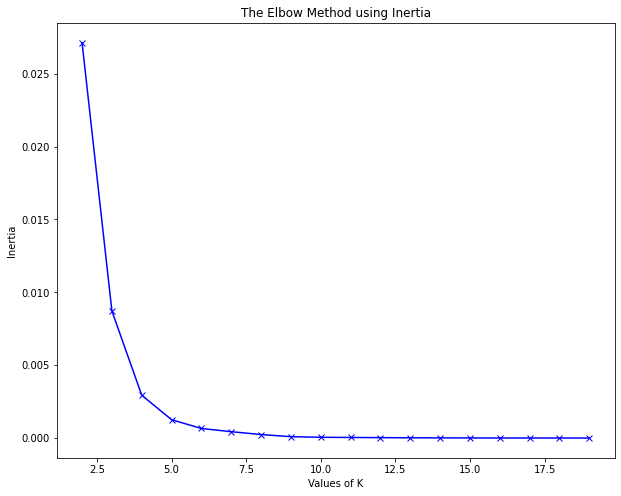

In [37]:
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show()

In [38]:
kclusters = 4

toronto_grouped_clustering = ita.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


array([0, 0, 0, 0, 1, 0, 0, 3, 0, 0], dtype=int32)

In [39]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

In [40]:
to_merged = ita.copy()

to_merged["Cluster Labels"] = kmeans.labels_

In [41]:
to_merged.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt                 0.0   
1                           Alderwood, Long Branch                 0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                 0.0   
3                                  Bayview Village                 0.0   
4                Bedford Park, Lawrence Manor East                 0.1   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               1

In [42]:
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(2145, 9)


Neighborhood  Italian Restaurant  Cluster Labels  Neighborhood Latitude  \
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   
0    Agincourt                 0.0               0                43.7942   

   Neighborhood Longitude                        Venue  Venue Latitude  \
0              -79.262029  Panagio's Breakfast & Lunch       43.792370   
0              -79.262029                El Pulgarcito       43.792648   
0              -79.262029                     Twilight       43.791999   
0              -79.262029                       Mark's       43.791179   
0              -79.262029              Commander Arena       43.794867   

   Venue Longitude             Venue Category  
0       -79.260203             Breakfast Spot  
0       -79.259208  Latin American Restaurant  
0       -79.258584                     Lounge  
0       -79.259714             Clothing Store  
0       -79.267989               Skating Rink

In [43]:
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.tail()

(2145, 9)


Neighborhood  Italian Restaurant  \
63                      Ontario Provincial Government            0.028571   
63                      Ontario Provincial Government            0.028571   
63                      Ontario Provincial Government            0.028571   
63                      Ontario Provincial Government            0.028571   
40  Harbourfront East, Union Station, Toronto Islands            0.020000   

    Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
63               3              43.662301              -79.389494   
63               3              43.662301              -79.389494   
63               3              43.662301              -79.389494   
63               3              43.662301              -79.389494   
40               3              43.640816              -79.381752   

            Venue  Venue Latitude  Venue Longitude         Venue Category  
63           SUDS       43.659880       -79.394712                    Bar  
63    Tim Hortons       43.658906       -79.388696            Coffee Shop  
63   CIUT 89.5 FM       43.663818       -79.395092  General Entertainment  
63  Booster Juice       43.658657       -79.388682          Smoothie Shop  
40      Pizzaiolo       43.639113       -79.387266            Pizza Place

In [44]:
to_merged['Venue Category'].value_counts()['Italian Restaurant']

39

# Visualización

In [45]:
# creando mapas
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [46]:
ita["Cluster Labels"] = kmeans.labels_
ita.head()

Neighborhood  Italian Restaurant  \
0                                        Agincourt                 0.0   
1                           Alderwood, Long Branch                 0.0   
2  Bathurst Manor, Wilson Heights, Downsview North                 0.0   
3                                  Bayview Village                 0.0   
4                Bedford Park, Lawrence Manor East                 0.1   

   Cluster Labels  
0               0  
1               0  
2               0  
3               0  
4               1

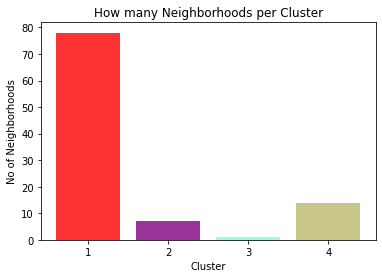

In [47]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('How many Neighborhoods per Cluster')

plt.show()

In [48]:
ita['Cluster Labels'].value_counts()

0    78
3    14
1     7
2     1
Name: Cluster Labels, dtype: int64

# Análisis de cada cluster

In [49]:
df_new = df[['Borough', 'Neighborhood']]
df_new.head()

Borough                      Neighborhood
0        North York                         Parkwoods
1        North York                  Victoria Village
2  Downtown Toronto         Regent Park, Harbourfront
3        North York  Lawrence Manor, Lawrence Heights
4      Queen's Park     Ontario Provincial Government

In [50]:
cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 0]
df_cluster1 = pd.merge(df_new, cluster1, on='Neighborhood')
df_cluster1.head()

Borough      Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York         Parkwoods                 0.0               0   
1  North York         Parkwoods                 0.0               0   
2  North York         Parkwoods                 0.0               0   
3  North York  Victoria Village                 0.0               0   
4  North York  Victoria Village                 0.0               0   

   Neighborhood Latitude  Neighborhood Longitude                   Venue  \
0              43.753259              -79.329656           Variety Store   
1              43.753259              -79.329656                     KFC   
2              43.753259              -79.329656         Brookbanks Park   
3              43.725882              -79.315572             Tim Hortons   
4              43.725882              -79.315572  Victoria Village Arena   

   Venue Latitude  Venue Longitude        Venue Category  
0       43.751974       -79.333114     Food & Drink Shop  
1       43.754387       -79.333021  Fast Food Restaurant  
2       43.751976       -79.332140                  Park  
3       43.725517       -79.313103           Coffee Shop  
4       43.723481       -79.315635          Hockey Arena

In [51]:
cluster2=to_merged.loc[to_merged['Cluster Labels'] == 1]
df_cluster2 = pd.merge(df_new, cluster2, on='Neighborhood')
df_cluster2.head()

Borough     Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York  Don Mills South            0.055556               1   
1  North York  Don Mills South            0.055556               1   
2  North York  Don Mills South            0.055556               1   
3  North York  Don Mills South            0.055556               1   
4  North York  Don Mills South            0.055556               1   

   Neighborhood Latitude  Neighborhood Longitude               Venue  \
0                43.7259              -79.340923  Fitness Connection   
1                43.7259              -79.340923              Oomomo   
2                43.7259              -79.340923  Sorento Restaurant   
3                43.7259              -79.340923              Subway   
4                43.7259              -79.340923        Swiss Chalet   

   Venue Latitude  Venue Longitude      Venue Category  
0       43.727473       -79.341707                 Gym  
1       43.726429       -79.343283      Discount Store  
2       43.726575       -79.341989  Italian Restaurant  
3       43.724322       -79.336858      Sandwich Place  
4       43.726747       -79.341625          Restaurant

In [52]:
cluster3 = to_merged.loc[to_merged['Cluster Labels'] == 2]
df_cluster3 = pd.merge(df_new, cluster3, on='Neighborhood')
df_cluster3.head()

Borough Neighborhood  Italian Restaurant  Cluster Labels  \
0  North York    Glencairn                 0.2               2   
1  North York    Glencairn                 0.2               2   
2  North York    Glencairn                 0.2               2   
3  North York    Glencairn                 0.2               2   
4  North York    Glencairn                 0.2               2   

   Neighborhood Latitude  Neighborhood Longitude  \
0              43.709577              -79.445073   
1              43.709577              -79.445073   
2              43.709577              -79.445073   
3              43.709577              -79.445073   
4              43.709577              -79.445073   

                                Venue  Venue Latitude  Venue Longitude  \
0  R Bakery - Delicious Cakes, Breads       43.707420       -79.443126   
1                      Domino's Pizza       43.707170       -79.442658   
2                    Filipino Grocery       43.705607       -79.442575   
3                      Pasta Goodness       43.709457       -79.443863   
4             Miyako Sushi Restaurant       43.709111       -79.443930   

        Venue Category  
0               Bakery  
1          Pizza Place  
2    Convenience Store  
3   Italian Restaurant  
4  Japanese Restaurant

In [53]:
cluster4 = to_merged.loc[to_merged['Cluster Labels'] == 3]
df_cluster4 = pd.merge(df_new, cluster4, on='Neighborhood')
df_cluster4.head()

Borough                   Neighborhood  Italian Restaurant  \
0  Queen's Park  Ontario Provincial Government            0.028571   
1  Queen's Park  Ontario Provincial Government            0.028571   
2  Queen's Park  Ontario Provincial Government            0.028571   
3  Queen's Park  Ontario Provincial Government            0.028571   
4  Queen's Park  Ontario Provincial Government            0.028571   

   Cluster Labels  Neighborhood Latitude  Neighborhood Longitude  \
0               3              43.662301              -79.389494   
1               3              43.662301              -79.389494   
2               3              43.662301              -79.389494   
3               3              43.662301              -79.389494   
4               3              43.662301              -79.389494   

            Venue  Venue Latitude  Venue Longitude         Venue Category  
0    Queen's Park       43.663946       -79.392180                   Park  
1         Nando's       43.661728       -79.386391  Portuguese Restaurant  
2        Mercatto       43.660391       -79.387664     Italian Restaurant  
3  NEO COFFEE BAR       43.660130       -79.385830            Coffee Shop  
4    Central YMCA       43.663083       -79.385025            Summer Camp

# Número de vecindarios y número de restaurantes italianos por cluster

Text(0.5, 1.0, 'Average number of Italian Restaurants per Cluster')

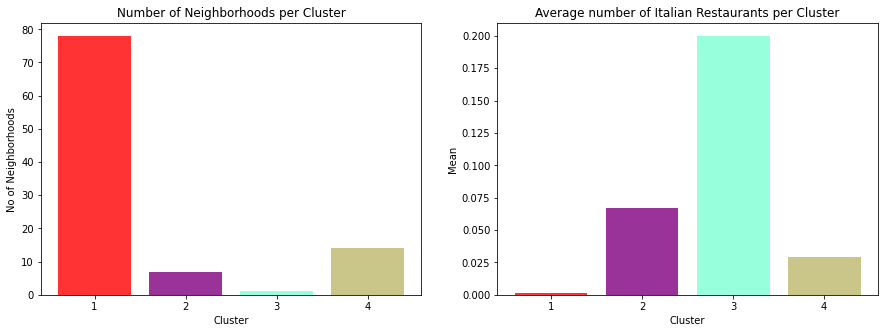

In [54]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf_1 = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf_1, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Neighborhoods')
plt.xlabel('Cluster')
plt.title('Number of Neighborhoods per Cluster')

plt.subplot(1, 2, 2)
clusters_mean = [df_cluster1['Italian Restaurant'].mean(),df_cluster2['Italian Restaurant'].mean(),df_cluster3['Italian Restaurant'].mean(),
                df_cluster4['Italian Restaurant'].mean()]
y_pos = np.arange(len(objects))
perf_2 = clusters_mean
plt.bar(y_pos, perf_2, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Italian Restaurants per Cluster')

# Conclusión
Los vecindarios ubicados en el área del este de Toronto (grupo 3) tienen el promedio más alto de restaurantes italianos, que está representado por el color aguamarina. North York tiene el segundo mayor número de restaurantes italianos presentes. En cuanto a los lugares cercanos, el lugar óptimo para poner un nuevo restaurante italiano es en Victoria Village, North York (cluster-1) ya que hay muchos vecindarios en esa área pero una pequeña cantidad de restaurantes italianos, por lo tanto, eliminando cualquier competencia. El segundo Los mejores vecindarios que tienen una gran oportunidad serían áreas como Queen's Park, que se encuentra en el Grupo 4. Tener 70 vecindarios en el área sin restaurantes italianos brinda una buena oportunidad para abrir un nuevo restaurante. Esto concluye los hallazgos óptimos para este proyecto y recomienda al emprendedor abrir un auténtico restaurante italiano en estos lugares con poca o ninguna competencia. No obstante, si la comida es auténtica, asequible y de buen gusto, estoy seguro de que tendrá muchos seguidores en todas partes.